<a href="https://colab.research.google.com/github/Raanjeetsgolu/Face-Detections/blob/main/FaceRecognation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Setup

## 1.1 Install Dependencies

In [2]:
#getting file
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!cp -r  /content/drive/MyDrive/data /content/data

In [4]:
!cp -r /content/drive/MyDrive/lfw  /content/lfw

In [5]:
!pip install tensorflow==2.15.0  opencv-python matplotlib

## 1.2 Import Dependencies

In [6]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [7]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.3 Set GPU Growth

In [8]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## 1.4 Create Folder Structures

In [9]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [ ]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# 2. Collect Positives and Anchors

## 2.1 Untar Labelled Faces in the Wild Dataset

In [ ]:
# http://vis-www.cs.umass.edu/lfw/

In [ ]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [ ]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

## 2.2 Collect Positive and Anchor Classes

In [10]:
# Import uuid library to generate unique image names
import uuid

In [11]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data/anchor/060d744c-f433-11ee-ba4e-0242ac1c000c.jpg'

In [150]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(output_folder, quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  # filename = str(uuid.uuid1()) + '.jpg'
  filename = os.path.join(output_folder, '{}.jpg'.format(uuid.uuid1()))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  # return filename


  frame = cv2.imread(filename)

  # Crop the image to 250x250 pixels
  cropped_frame = frame[120:370, 200:450, :]  # Adjust the slicing indices as needed

  # Save the cropped image
  cv2.imwrite(filename, cropped_frame)

  return filename

<IPython.core.display.Javascript object>

Saved to data/positive/1edba430-f433-11ee-ba4e-0242ac1c000c.jpg


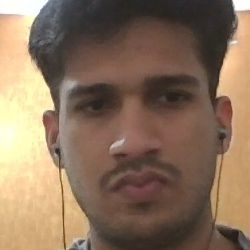

<IPython.core.display.Javascript object>

Saved to data/positive/22782afa-f433-11ee-ba4e-0242ac1c000c.jpg


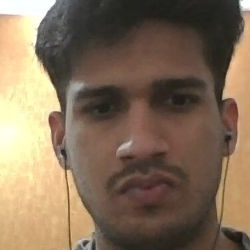

<IPython.core.display.Javascript object>

Saved to data/positive/2535473c-f433-11ee-ba4e-0242ac1c000c.jpg


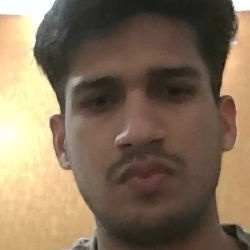

In [13]:
from IPython.display import Image
for  i in range(3):
  try:

    filename = take_photo(POS_PATH)
    print('Saved to {}'.format(filename))
    # imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
    # cv2.imwrite(imgname, filename)

    # Show the image which was just taken.
    display(Image(filename))
  except Exception as err:
    # Errors will be thrown if the user does not have a webcam or if they do not
    # grant the page permission to access it.
    print(str(err))
  i +=1

# 2.x NEW - Data Augmentation

In [15]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))

        data.append(img)

    return data

In [16]:
import os
import uuid

In [17]:
img_path = os.path.join(ANC_PATH, '20b2c7b8-f05d-11ee-b446-0242ac1c000c.jpg')
img = cv2.imread(img_path)
augmented_images = data_aug(img)

for image in augmented_images:
    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [18]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img)

    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

# 3. Load and Preprocess Images

## 3.1 Get Image Directories

In [19]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(30)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(30)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(30)

In [20]:
dir_test = anchor.as_numpy_iterator()

In [21]:
print(dir_test.next())

b'data/anchor/1c3fa7bc-f05f-11ee-b446-0242ac1c000c.jpg'


## 3.2 Preprocessing - Scale and Resize

In [22]:
def preprocess(file_path):

    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image
    img = tf.io.decode_jpeg(byte_img)

    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1
    img = img / 255.0

    # Return image
    return img

In [23]:
img = preprocess('data/anchor/329a991a-f05d-11ee-b446-0242ac1c000c.jpg')

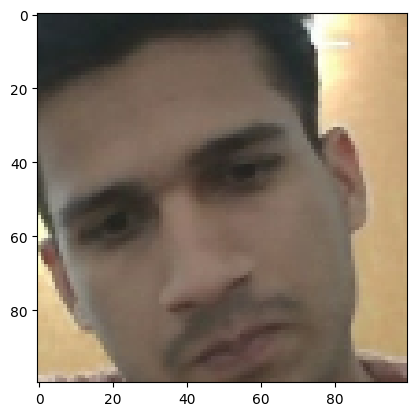

In [24]:
plt.imshow(img)

In [25]:
img.numpy().max()

1.0

In [ ]:
dataset.map(preprocess)

NameError: name 'dataset' is not defined

## 3.3 Create Labelled Dataset

In [ ]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [26]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [27]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [28]:
samples = data.as_numpy_iterator()

In [29]:
example = samples.next()

In [30]:
example

(b'data/anchor/b1833214-f05d-11ee-b446-0242ac1c000c.jpg',
 b'data/positive/63a8705c-f433-11ee-ba4e-0242ac1c000c.jpg',
 1.0)

## 3.4 Build Train and Test Partition

In [31]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [32]:
res = preprocess_twin(*example)

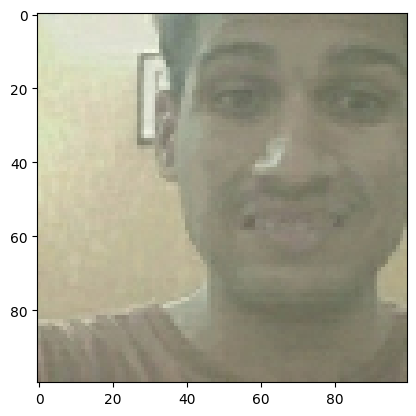

In [33]:
plt.imshow(res[1])

In [34]:
res[2]

1.0

In [35]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [36]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [37]:
train_samples = train_data.as_numpy_iterator()

In [38]:
train_samples.next()

(array([[[[0.9911765 , 0.9911765 , 0.85588235],
          [0.9980392 , 0.9990196 , 0.90931374],
          [0.99313724, 1.        , 0.95392156],
          ...,
          [0.17745098, 0.18921569, 0.16176471],
          [0.18431373, 0.19607843, 0.16862746],
          [0.19142157, 0.21102941, 0.18357843]],
 
         [[0.9911765 , 0.9911765 , 0.85588235],
          [0.99215686, 0.9990196 , 0.9107843 ],
          [0.99215686, 1.        , 0.95416665],
          ...,
          [0.1764706 , 0.1882353 , 0.15490197],
          [0.18137255, 0.19901961, 0.17230392],
          [0.19044118, 0.21004902, 0.18848039]],
 
         [[0.9911765 , 0.9889706 , 0.8617647 ],
          [0.99215686, 0.9990196 , 0.9127451 ],
          [0.99215686, 1.        , 0.95490193],
          ...,
          [0.1629902 , 0.1747549 , 0.14142157],
          [0.17892157, 0.18995099, 0.16764706],
          [0.1889706 , 0.20833333, 0.19338235]],
 
         ...,
 
         [[0.5448529 , 0.42083332, 0.31862745],
          [0.57352

In [39]:
train_sample =train_samples.next()

In [40]:
len(train_sample[0])

16

In [41]:
round(len(data)*.3)

18

In [42]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(10)
test_data = test_data.prefetch(5)

# 4. Model Engineering

## 4.1 Build Embedding Layer

In [ ]:
inp = Input(shape=(100,100,3), name='input_image')

In [ ]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [ ]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [ ]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [ ]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [ ]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [ ]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [ ]:
mod.summary()

In [ ]:
inp = Input(shape=(105,105,3), name='input_image')


In [ ]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)


In [ ]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)


In [ ]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [ ]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [ ]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [ ]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [ ]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 48, 48, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 21, 21, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 18, 18, 128)       26

In [85]:
def make_embedding():
    inp = Input(shape=(100,100,3), name='input_image')

    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    # Third block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)


    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [86]:
embedding = make_embedding()

In [87]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 46, 46, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 17, 17, 128)       26

## 4.2 Build Distance Layer

In [88]:
# Siamese L1 Distance class
class L1Dist(Layer):

    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()

    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [89]:
l1 = L1Dist()

In [90]:
l1

In [57]:
l1(anchor_embedding, validation_embedding)

NameError: name 'anchor_embedding' is not defined

## 4.3 Make Siamese Model

In [91]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [92]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [93]:
val_embedding

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'embedding')>

In [94]:
siamese_layer = L1Dist()
siamese_layer._name = 'distance'

In [95]:
distances = siamese_layer(inp_embedding, val_embedding)


In [96]:
classifier = Dense(1, activation='sigmoid')(distances)

In [97]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_5')>

In [98]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [99]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [100]:
def make_siamese_model():

    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))

    # Validation image in the network
    validation_image = Input(name='validation_img', shape=(100,100,3))

    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [101]:
siamese_model = make_siamese_model()

In [102]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

# 5. Training

## 5.1 Setup Loss and Optimizer

In [103]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [104]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## 5.2 Establish Checkpoints

In [105]:
checkpoint_dir = '/content/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function

In [106]:
test_batch = train_data.as_numpy_iterator()

In [107]:
batch_1 = test_batch.next()

In [108]:
X = batch_1[:2]

In [109]:
y = batch_1[2]

In [110]:
y

array([1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0.],
      dtype=float32)

In [ ]:
tf.losses.BinaryCrossentropy??

In [111]:
@tf.function
def train_step(batch):

    # Record all of our operations
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]

        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)

    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    # Return loss
    return loss

## 5.4 Build Training Loop

In [112]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [113]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        # Creating a metric object
        r = Recall()
        p = Precision()

        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())

        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train the model

In [114]:
EPOCHS = 50

In [115]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
3/3 [==============================] - 12s 934ms/step
0.6812295 0.15 1.0

 Epoch 2/50
3/3 [==============================] - 1s 231ms/step
0.5278803 0.05263158 1.0

 Epoch 3/50
3/3 [==============================] - 1s 204ms/step
0.31512696 0.36842105 1.0

 Epoch 4/50
3/3 [==============================] - 1s 227ms/step
0.19656637 0.8095238 1.0

 Epoch 5/50
3/3 [==============================] - 1s 304ms/step
0.2790932 0.85714287 1.0

 Epoch 6/50
3/3 [==============================] - 1s 206ms/step
0.19370706 1.0 1.0

 Epoch 7/50
3/3 [==============================] - 1s 229ms/step
0.1144491 0.8333333 1.0

 Epoch 8/50
3/3 [==============================] - 1s 212ms/step
0.14184894 1.0 1.0

 Epoch 9/50
3/3 [==============================] - 1s 221ms/step
0.099185035 1.0 1.0

 Epoch 10/50
3/3 [==============================

# 6. Evaluate Model

## 6.1 Import Metrics

In [116]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Make Predictions

In [117]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [118]:
test_input

array([[[[0.24901961, 0.2372549 , 0.20980392],
         [0.21666667, 0.20490196, 0.17745098],
         [0.2129902 , 0.20122549, 0.16789216],
         ...,
         [0.70980394, 0.58137256, 0.43235293],
         [0.7147059 , 0.5686275 , 0.41470587],
         [0.7088235 , 0.5637255 , 0.39019608]],

        [[0.24313726, 0.23137255, 0.19607843],
         [0.21666667, 0.20588236, 0.16764706],
         [0.20686275, 0.19534314, 0.15931372],
         ...,
         [0.72745097, 0.5990196 , 0.45      ],
         [0.72843134, 0.58235294, 0.42843136],
         [0.7058824 , 0.57254905, 0.39509803]],

        [[0.2529412 , 0.24411765, 0.2       ],
         [0.23333333, 0.2254902 , 0.17843138],
         [0.21764706, 0.20906863, 0.16421568],
         ...,
         [0.7370098 , 0.60857844, 0.45735294],
         [0.72794116, 0.5884804 , 0.43235293],
         [0.70980394, 0.5764706 , 0.3990196 ]],

        ...,

        [[0.4776961 , 0.36789215, 0.35220587],
         [0.4747549 , 0.36666667, 0.34583333]

In [119]:
test_var =  test_data.as_numpy_iterator().next()

In [120]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 22ms/step


In [121]:
y_hat

array([[1.0000000e+00],
       [2.7074699e-07],
       [9.9999988e-01],
       [9.9906117e-01],
       [9.9940145e-01],
       [8.5424754e-06],
       [9.9981707e-01],
       [1.0000000e+00],
       [1.5913950e-04],
       [9.9999857e-01]], dtype=float32)

In [122]:
# Post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 0, 1, 1, 1, 0, 1, 1, 0, 1]

In [123]:
y_true

array([1., 0., 1., 1., 1., 0., 1., 1., 0., 1.], dtype=float32)

## 6.3 Calculate Metrics

In [124]:
# Creating a metric object
m = Recall()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [125]:
# Creating a metric object
m = Precision()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [126]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat)

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 1s 522ms/step
1.0 1.0


## 6.4 Viz Results

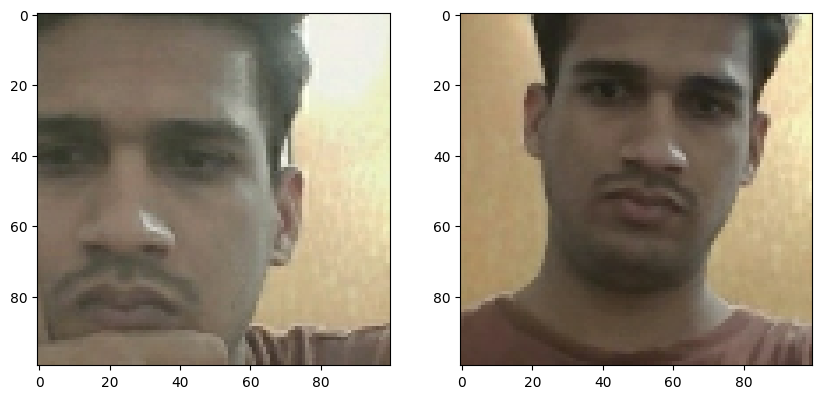

In [127]:
# Set plot size
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[3])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[3])

# Renders cleanly
plt.show()

# 7. Save Model

In [128]:
# Save weights
siamese_model.save('siamesemodelv1.h1')

In [ ]:
L1Dist

__main__.L1Dist

In [130]:
# Reload model
siamese_model = tf.keras.models.load_model('siamesemodelv1.h1',
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [131]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 184ms/step


array([[9.9999952e-01],
       [2.7074751e-07],
       [3.1987150e-07],
       [9.9881929e-01],
       [3.4031189e-07],
       [9.9999595e-01],
       [1.0621025e-05],
       [6.2192464e-07]], dtype=float32)

In [132]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

# 8. Real Time Test

## 8.1 Verification Function

In [151]:
VERIFICATION_IMAGE_PATH=os.path.join('application_data', 'verification_images')
INPUT_IMAGE_PATH=os.path.join('application_data', 'input_image')

In [142]:
#creating application flfer
os.makedirs(VERIFICATION_IMAGE_PATH)
os.makedirs(INPUT_IMAGE_PATH)

In [146]:
#copy 50 files from positive to application_data/verification_images
import shutil

def copy_files(source_folder, destination_folder, num_files):
    # Get the list of files in the source folder
    files = os.listdir(source_folder)

    # Make sure the destination folder exists, create it if not
    os.makedirs(destination_folder, exist_ok=True)

    # Copy the specified number of files
    for i in range(num_files):
        # Make sure we don't exceed the number of files available
        if i < len(files):
            file_to_copy = os.path.join(source_folder, files[i])
            shutil.copy(file_to_copy, destination_folder)


In [147]:
# Example usage
source_folder = "/content/data/positive"
destination_folder = "/content/application_data/verification_images"
num_files_to_copy = 50  # Change this to the number of files you want to copy

copy_files(source_folder, destination_folder, num_files_to_copy)

In [148]:
os.listdir(os.path.join('application_data', 'verification_images'))

['22fd0234-f05f-11ee-b446-0242ac1c000c.jpg',
 '858e820c-f05e-11ee-b446-0242ac1c000c.jpg',
 '21ccf018-f05f-11ee-b446-0242ac1c000c.jpg',
 '221485b8-f05f-11ee-b446-0242ac1c000c.jpg',
 '23316420-f05f-11ee-b446-0242ac1c000c.jpg',
 '21554d60-f05f-11ee-b446-0242ac1c000c.jpg',
 '227d05a2-f05f-11ee-b446-0242ac1c000c.jpg',
 '227d5fca-f05f-11ee-b446-0242ac1c000c.jpg',
 '21e05f18-f05f-11ee-b446-0242ac1c000c.jpg',
 '219a87e0-f05f-11ee-b446-0242ac1c000c.jpg',
 '2177ca5c-f05f-11ee-b446-0242ac1c000c.jpg',
 '914c6bc2-f05e-11ee-b446-0242ac1c000c.jpg',
 '22c6e58c-f05f-11ee-b446-0242ac1c000c.jpg',
 '23311fe2-f05f-11ee-b446-0242ac1c000c.jpg',
 '21f28c60-f05f-11ee-b446-0242ac1c000c.jpg',
 '21315dc4-f05f-11ee-b446-0242ac1c000c.jpg',
 '21653270-f05f-11ee-b446-0242ac1c000c.jpg',
 '22027918-f05f-11ee-b446-0242ac1c000c.jpg',
 '21778948-f05f-11ee-b446-0242ac1c000c.jpg',
 '22269226-f05f-11ee-b446-0242ac1c000c.jpg',
 '22ea3db6-f05f-11ee-b446-0242ac1c000c.jpg',
 'a69a6f1a-f05e-11ee-b446-0242ac1c000c.jpg',
 '213119ae

In [144]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data/input_image/input_image.jpg'

In [149]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data/verification_images/22fd0234-f05f-11ee-b446-0242ac1c000c.jpg
application_data/verification_images/858e820c-f05e-11ee-b446-0242ac1c000c.jpg
application_data/verification_images/21ccf018-f05f-11ee-b446-0242ac1c000c.jpg
application_data/verification_images/221485b8-f05f-11ee-b446-0242ac1c000c.jpg
application_data/verification_images/23316420-f05f-11ee-b446-0242ac1c000c.jpg
application_data/verification_images/21554d60-f05f-11ee-b446-0242ac1c000c.jpg
application_data/verification_images/227d05a2-f05f-11ee-b446-0242ac1c000c.jpg
application_data/verification_images/227d5fca-f05f-11ee-b446-0242ac1c000c.jpg
application_data/verification_images/21e05f18-f05f-11ee-b446-0242ac1c000c.jpg
application_data/verification_images/219a87e0-f05f-11ee-b446-0242ac1c000c.jpg
application_data/verification_images/2177ca5c-f05f-11ee-b446-0242ac1c000c.jpg
application_data/verification_images/914c6bc2-f05e-11ee-b446-0242ac1c000c.jpg
application_data/verification_images/22c6e58c-f05f-11ee-b446-024

In [140]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))

        # Make Predictions
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)

    # Detection Threshold: Metric above which a prediciton is considered positive
    detection = np.sum(np.array(results) > detection_threshold)

    # Verification Threshold: Proportion of positive predictions / total positive samples
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
    verified = verification > verification_threshold

    return results, verified

## 8.2 OpenCV Real Time Verification

In [ ]:
cap = cv2.VideoCapture(4)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]

    cv2.imshow('Verification', frame)

    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10

#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [157]:
from IPython.display import Image
FOLDER_PATH='/content/application_data/input_image'
try:
  filename = take_photo(FOLDER_PATH)
  os.rename(filename, FOLDER_PATH/'input_image.jpg')
  print('Saved to {}'.format(filename))
  results, verified = verify(siamese_model, 0.5, 0.5)
  print(verified)

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))
i +=1

<IPython.core.display.Javascript object>

unsupported operand type(s) for /: 'str' and 'str'


<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 31ms/step
True


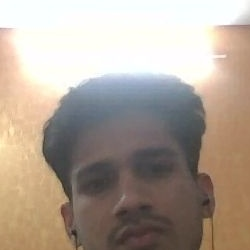

In [159]:
from IPython.display import Image

FOLDER_PATH = '/content/application_data/input_image'

try:
    filename = take_photo(FOLDER_PATH)
    new_filename = os.path.join(FOLDER_PATH, 'input_image.jpg')
    os.rename(filename, new_filename)
    results, verified = verify(siamese_model, 0.5, 0.5)
    print(verified)

    # Show the image which was just taken.
    display(Image(new_filename))
except Exception as err:
    # Errors will be thrown if the user does not have a webcam or if they do not
    # grant the page permission to access it.
    print(str(err))


In [160]:
np.sum(np.squeeze(results) > 0.9)

40

In [161]:
results

[array([[0.99999964]], dtype=float32),
 array([[0.99946076]], dtype=float32),
 array([[0.922649]], dtype=float32),
 array([[0.7577625]], dtype=float32),
 array([[0.99944705]], dtype=float32),
 array([[0.95615983]], dtype=float32),
 array([[0.58189976]], dtype=float32),
 array([[0.53084743]], dtype=float32),
 array([[0.99247336]], dtype=float32),
 array([[0.99730325]], dtype=float32),
 array([[0.9989453]], dtype=float32),
 array([[0.9990356]], dtype=float32),
 array([[0.83046603]], dtype=float32),
 array([[0.9995906]], dtype=float32),
 array([[0.99983966]], dtype=float32),
 array([[0.9999957]], dtype=float32),
 array([[0.9969887]], dtype=float32),
 array([[0.99903286]], dtype=float32),
 array([[0.9997609]], dtype=float32),
 array([[0.8591275]], dtype=float32),
 array([[0.9999732]], dtype=float32),
 array([[0.99977547]], dtype=float32),
 array([[0.99996984]], dtype=float32),
 array([[0.9999995]], dtype=float32),
 array([[0.9794779]], dtype=float32),
 array([[0.81054914]], dtype=float32),

In [162]:
import shutil
import os

def download_files_and_folders(directory_path):
    try:
        # Zip the entire directory
        shutil.make_archive("/content/files", 'zip', directory_path)

        print("Files zipped and ready for download.")
    except Exception as e:
        print(f"Error: {e}")

# Example usage
download_files_and_folders("/content/application_data")


Files zipped and ready for download.


In [163]:
from google.colab import files

files.download('/content/files.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>